In [10]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [11]:
from numpy import dstack
from pandas import read_csv
 
# load a single file as a numpy array
def load_file(filepath):
 dataframe = read_csv(filepath, header=None, delim_whitespace=True)
 return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
 loaded = list()
 for name in filenames:
  data = load_file(prefix + name)
  loaded.append(data)
 # stack group so that features are the 3rd dimension
 loaded = dstack(loaded)
 return loaded
 
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
 filepath = prefix + group + '/Inertial Signals/'
 # load all 9 files as a single array
 filenames = list()
 # total acceleration
 filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
 # body acceleration
 filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
 # body gyroscope
 filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
 # load input data
 X = load_group(filenames, filepath)
 # load class output
 y = load_file(prefix + group + '/y_'+group+'.txt')
 return X, y
 
# load all train
trainX, trainy = load_dataset('train', '/content/drive/My Drive/datasets/UCI HAR Dataset/')
print(trainX.shape, trainy.shape)
# load all test
testX, testy = load_dataset('test', '/content/drive/My Drive/datasets/UCI HAR Dataset/')
print(testX.shape, testy.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


In [12]:
import tensorflow as tf
trainy = trainy - 1
testy = testy - 1
trainy = tf.keras.utils.to_categorical(trainy)
testy = tf.keras.utils.to_categorical(testy)

In [13]:
model = tf.keras.Sequential([
    
tf.keras.layers.Conv1D(64, 3, activation='relu', padding = 'Same', input_shape=(128, 9)),
tf.keras.layers.MaxPooling1D(2, padding='same'),
tf.keras.layers.Conv1D(32, 3, activation='relu', padding = 'Same'),
tf.keras.layers.MaxPooling1D(2, padding='same'),

tf.keras.layers.Conv1D(32, 3, activation='relu', padding = 'Same'),
tf.keras.layers.UpSampling1D(2),
tf.keras.layers.Conv1D(64, 3, activation='relu', padding = 'Same'),
tf.keras.layers.UpSampling1D(2),

tf.keras.layers.Dropout(0.5),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(100, activation='relu'),
tf.keras.layers.Dense(6, activation='softmax')])

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 128, 64)           1792      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 64, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 64, 32)            6176      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 32, 32)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 32, 32)            3104      
                                                                 
 up_sampling1d_2 (UpSampling  (None, 64, 32)          

In [14]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
convae_output = model.fit(
  x=trainX, 
  y=trainy, 
  epochs=20,
  batch_size = 128,
  validation_data = (testX,testy),
  callbacks = [early_stop]
)

Epoch 1/20
58/58 [==============================] - 21s 258ms/step - loss: 0.5405 - accuracy: 0.7803 - val_loss: 0.5109 - val_accuracy: 0.8507
Epoch 2/20
58/58 [==============================] - 8s 130ms/step - loss: 0.1636 - accuracy: 0.9391 - val_loss: 0.4779 - val_accuracy: 0.8965
Epoch 3/20
58/58 [==============================] - 8s 138ms/step - loss: 0.1178 - accuracy: 0.9512 - val_loss: 0.5072 - val_accuracy: 0.8890
Epoch 4/20
58/58 [==============================] - 6s 101ms/step - loss: 0.1131 - accuracy: 0.9513 - val_loss: 0.5138 - val_accuracy: 0.8887
Epoch 5/20
58/58 [==============================] - 8s 137ms/step - loss: 0.1015 - accuracy: 0.9561 - val_loss: 0.5125 - val_accuracy: 0.9006
Epoch 6/20
58/58 [==============================] - 6s 100ms/step - loss: 0.1143 - accuracy: 0.9504 - val_loss: 0.3768 - val_accuracy: 0.8958
Epoch 7/20
58/58 [==============================] - 8s 141ms/step - loss: 0.0981 - accuracy: 0.9540 - val_loss: 0.4914 - val_accuracy: 0.8996
Epoch

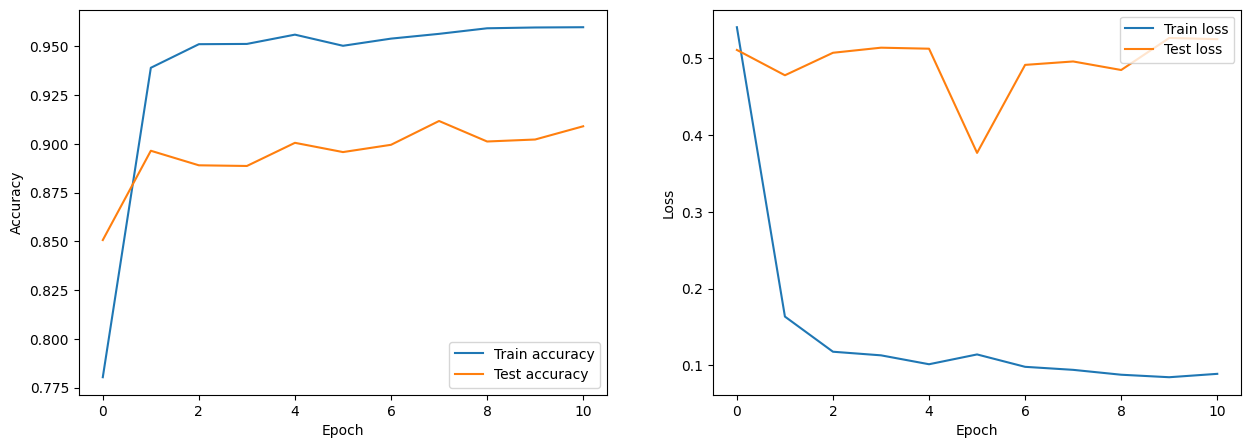

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(convae_output.history['accuracy'], label='accuracy')
plt.plot(convae_output.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy','Test accuracy'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(convae_output.history['loss'], label='loss')
plt.plot(convae_output.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss','Test loss'], loc='upper right')

In [16]:
import numpy as np
def recogniseActivity(l):
  labelIndex = np.argmax(l)
  l[:]=0
  for i in range(6):
    if i==labelIndex:
      l[i]=1
  return l

testList = [0,7,16,29,36,42,50,65,73,86,94,100,151,628,757,921,1000,1311,1954,2231,2569,2946]
for i in testList:
  y_pred = recogniseActivity(model.predict(np.expand_dims(testX[i], axis=0))[0])
  print(y_pred,testy[i])

1/1 [==============================] - 0s 151ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 25ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 23ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 24ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 22ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 24ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 23ms/step
[0. 0. 0. 0. 1. 0.] [0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 22ms/step
[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]
1/1 [==============================] - 0s 23ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 27ms/step
[1. 0. 0. 0. 0. 0.] [1. 0. 

In [17]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from keras.utils import to_categorical

y_pred = model.predict(testX)
pred_labels = to_categorical(np.argmax(y_pred, axis=1))
print(accuracy_score(testy,pred_labels))
print(precision_score(testy,pred_labels,average='weighted'))
print(recall_score(testy,pred_labels,average='weighted'))


93/93 [==============================] - 1s 8ms/step
0.9090600610790635
0.9123501990950601
0.9090600610790635


93/93 [==============================] - 1s 13ms/step


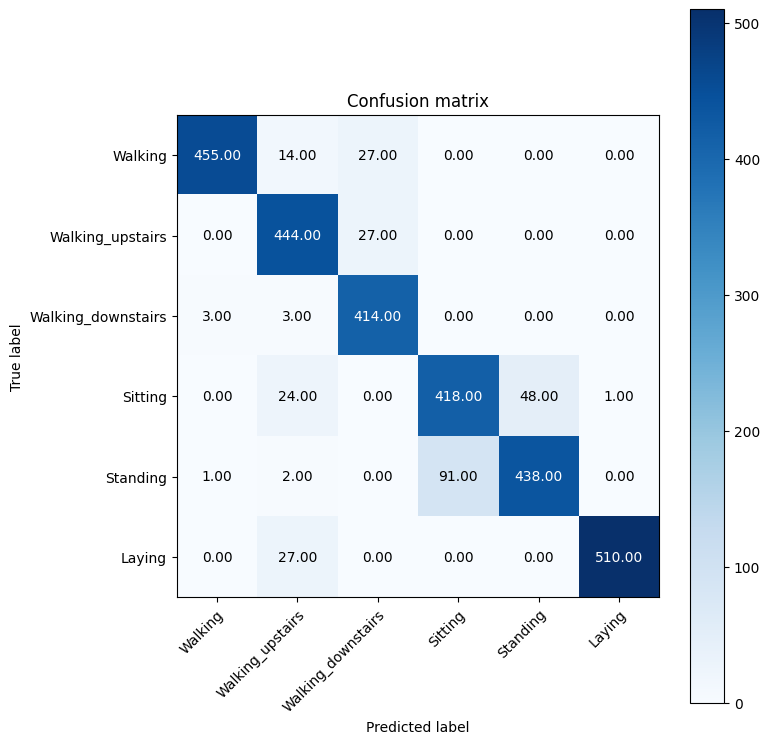

In [18]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix

cm = confusion_matrix(np.argmax(testy, axis=1), np.argmax(to_categorical(np.argmax(model.predict(testX), axis=1)),axis=1))

# Define class names (6 classes)
class_names = ['Walking', 'Walking_upstairs', 'Walking_downstairs', 'Sitting', 'Standing', 'Laying']

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion matrix')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = '.2f'  # set format for decimal places
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()